<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/keyuanren/RenTaGSim_GraphEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Type-Aware Graph Embedding

### Loading New Dataset

In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the train data from the drive
id = '1s7ng3JypVvjtoUF8eUFPGroCTNtkxzIE'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('updated_train.zip')
#get the test data from the drive
id = '11FK00L91jajUW15hzjsskNkN0DRsS_yN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('updated_test.zip')
!ls

sample_data  updated_test.zip  updated_train.zip


In [2]:
#if train and test exist do not run this part
#removing the dialog
%%capture
#unzip the file
!unzip updated_train.zip
!unzip updated_test.zip

### Data visualization

First graph: 2028.gexf


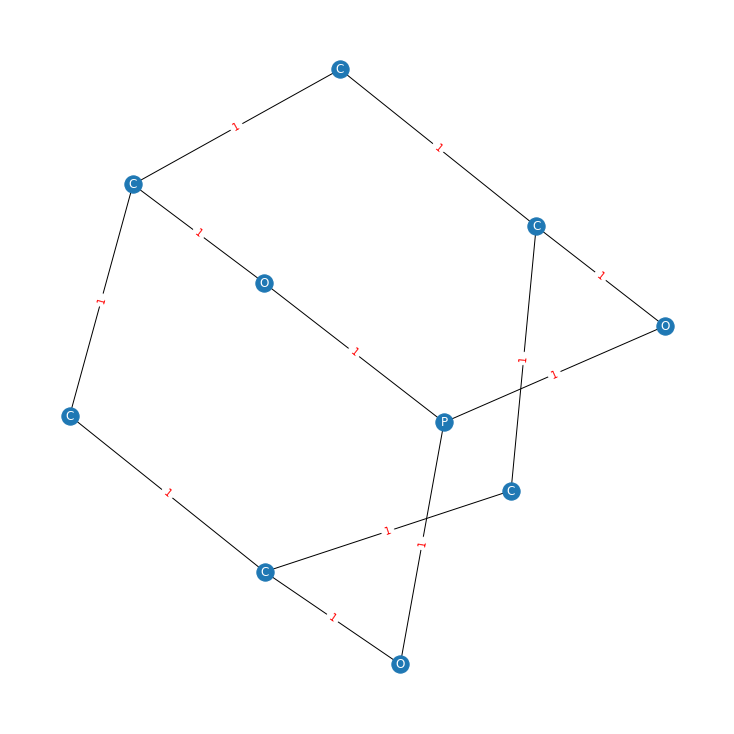

Second graph: 4241341143_2028.gexf


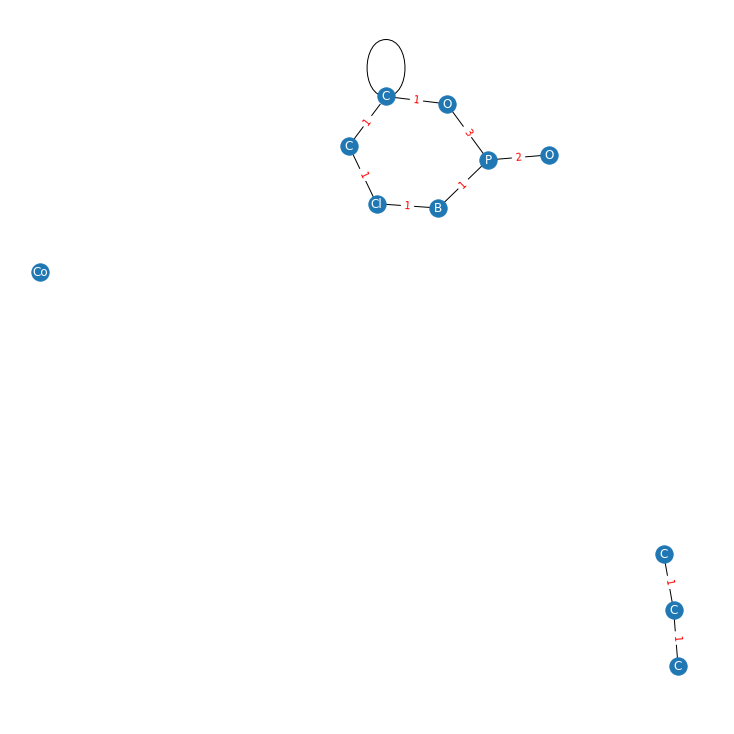

Their GEV: 4241341143


In [3]:
# pick a pair graph
import os
import random
import matplotlib.pyplot as plt
import networkx as nx

dirName = 'updated_train/'
filenames = os.listdir(dirName)

#pick random pair
pair_1 = random.choice(filenames)
while '_' in pair_1:
  pair_1 = random.choice(filenames)
for filename in filenames:
    if filename.endswith("_"+pair_1):
      pair_2 = filename
      gev = pair_2.split('_', 1)[0]
#read pair 1
print("First graph: "+pair_1)
graph1 = nx.read_gexf('updated_train/'+pair_1,version='1.2draft')

node_info = nx.get_node_attributes(graph1, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph1.edges(data=True)])

#graph display
pos = nx.spring_layout(graph1, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph1, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph1, pos, edge_labels=edge_info, font_color="red")
plt.show()
#read pair 2
print("Second graph: "+pair_2)
graph2 = nx.read_gexf('updated_train/'+pair_2,version='1.2draft')

node_info = nx.get_node_attributes(graph2, 'type')
edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in graph2.edges(data=True)])

#graph display
pos = nx.spring_layout(graph2, scale=1.5)  
plt.figure(1,figsize=(10,10)) 
nx.draw(graph2, pos, labels=node_info, font_color="white")
nx.draw_networkx_edge_labels(graph2, pos, edge_labels=edge_info, font_color="red")
plt.show()
print("Their GEV: "+gev)